In [3]:
import numpy as np
import os
import matplotlib.pyplot as plt
from collections import Counter
from PIL import Image

In [4]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [5]:
from pathlib import Path

In [6]:
data_dir = Path("C:/Users/Nightmare/Downloads/samples/")
images = sorted(list(map(str,list(data_dir.glob("*.png")))))
labels = [img.split(os.path.sep)[-1].split(".png")[0] for img in images]

(50, 200, 4)
(200, 50, 4)


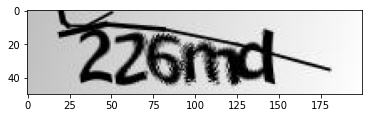

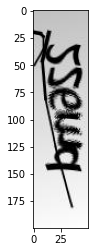

In [7]:
imga = Image.open(images[0])
arr = np.array(imga)
print(arr.shape)
arr2 = np.transpose(arr,[1,0,2])
print(arr2.shape)
plt.imshow(imga)
plt.show()
plt.imshow(arr2)
plt.show()

In [8]:
characters = set(char for label in labels for char in label)
characters = sorted(list(characters))

print(characters)

['2', '3', '4', '5', '6', '7', '8', 'b', 'c', 'd', 'e', 'f', 'g', 'm', 'n', 'p', 'w', 'x', 'y']


In [9]:
print("Number of images found: ",len(images))
print("Number of labels found: ",len(labels))
print("Number of unique characters: ",len(characters))
print("Characters present: ",characters)

Number of images found:  1040
Number of labels found:  1040
Number of unique characters:  19
Characters present:  ['2', '3', '4', '5', '6', '7', '8', 'b', 'c', 'd', 'e', 'f', 'g', 'm', 'n', 'p', 'w', 'x', 'y']


In [10]:
batch_size = 16
img_width = 200
img_height = 50
downsample_factor = 4
max_length = max([len(label) for label in labels])

In [11]:
print(max_length)
char_to_num = layers.StringLookup(vocabulary=list(characters),mask_token=None)
print(char_to_num(tf.constant(['2','d','d','n'])))
print(char_to_num.get_vocabulary())

5
tf.Tensor([ 1 10 10 15], shape=(4,), dtype=int64)
['[UNK]', '2', '3', '4', '5', '6', '7', '8', 'b', 'c', 'd', 'e', 'f', 'g', 'm', 'n', 'p', 'w', 'x', 'y']


In [12]:
images[0: 1]

['C:\\Users\\Nightmare\\Downloads\\samples\\226md.png']

In [13]:
char_to_num = layers.StringLookup(vocabulary=list(characters),mask_token=None)
num_to_char = layers.StringLookup(vocabulary=char_to_num.get_vocabulary(),mask_token=None,invert=True)

def split_data(images,labels, train_size=0.9,shuffle=True):
    size = len(images)
    indices = np.arange(size)
    print(indices)
    if shuffle:
        np.random.shuffle(indices)
    train_samples = int(size * train_size)
    print(indices[:train_samples].shape)
    x_train, y_train = images[indices[:train_samples]], labels[indices[:train_samples]]
    x_valid, y_valid = images[indices[train_samples:]], labels[indices[train_samples:]]
    return x_train,x_valid,y_train,y_valid

x_train, x_valid,y_train,y_valid = split_data(np.array(images),np.array(labels))

[   0    1    2 ... 1037 1038 1039]
(936,)


In [14]:
def encode_single_sample(img_path,label):
    img = tf.io.read_file(img_path)
    img = tf.io.decode_png(img,channels=1)
    img = tf.image.convert_image_dtype(img,tf.float32)
    img = tf.image.resize(img,[img_height, img_width])
    img = tf.transpose(img,perm=[1,0,2])
    label = char_to_num(tf.strings.unicode_split(label,input_encoding="UTF-8"))
    return {"image":img,"label":label}

In [15]:
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_dataset = (
    train_dataset.map(
        encode_single_sample, num_parallel_calls=tf.data.AUTOTUNE
    )
    .batch(batch_size)
    .prefetch(buffer_size=tf.data.AUTOTUNE)
)

validation_dataset = tf.data.Dataset.from_tensor_slices((x_valid, y_valid))
validation_dataset = (
    validation_dataset.map(
        encode_single_sample, num_parallel_calls=tf.data.AUTOTUNE
    )
    .batch(batch_size)
    .prefetch(buffer_size=tf.data.AUTOTUNE)
)

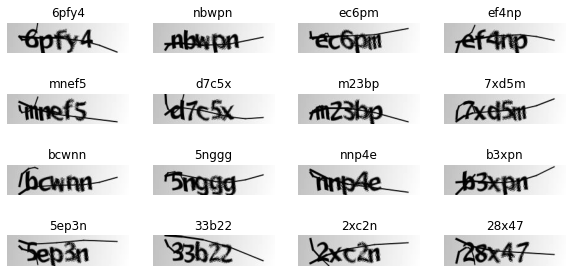

In [16]:
_, ax = plt.subplots(4, 4, figsize=(10, 5))
for batch in train_dataset.take(1):
    images = batch["image"]
    labels = batch["label"]
    for i in range(16):
        img = (images[i] * 255).numpy().astype("uint8")
        label = tf.strings.reduce_join(num_to_char(labels[i])).numpy().decode("utf-8")
        ax[i // 4, i % 4].imshow(img[:, :, 0].T, cmap="gray")
        ax[i // 4, i % 4].set_title(label)
        ax[i // 4, i % 4].axis("off")

In [17]:
class CTCLayer(layers.Layer):
    def __init__(self,name=None):
        super(CTCLayer,self).__init__(name=name)
        self.loss_fn = keras.backend.ctc_batch_cost
        
    def call(self, y_true, y_pred):
        # Compute the training-time loss value and add it
        # to the layer using `self.add_loss()`.
        batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
        input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
        label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

        input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
        label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")

        loss = self.loss_fn(y_true, y_pred, input_length, label_length)
        self.add_loss(loss)

        # At test time, just return the computed predictions
        return y_pred

In [18]:
def build_model():
    # Inputs to the model
    input_img = layers.Input(
        shape=(img_width, img_height, 1), name="image", dtype="float32"
    )
    labels = layers.Input(name="label", shape=(None,), dtype="float32")

    # First conv block
    x = layers.Conv2D(
        32,
        (3, 3),
        activation="relu",
        kernel_initializer="he_normal",
        padding="same",
        name="Conv1",
    )(input_img)
    x = layers.MaxPooling2D((2, 2), name="pool1")(x)

    # Second conv block
    x = layers.Conv2D(
        64,
        (3, 3),
        activation="relu",
        kernel_initializer="he_normal",
        padding="same",
        name="Conv2",
    )(x)
    x = layers.MaxPooling2D((2, 2), name="pool2")(x)

    # We have used two max pool with pool size and strides 2.
    # Hence, downsampled feature maps are 4x smaller. The number of
    # filters in the last layer is 64. Reshape accordingly before
    # passing the output to the RNN part of the model
    new_shape = ((img_width // 4), (img_height // 4) * 64)
    x = layers.Reshape(target_shape=new_shape, name="reshape")(x)
    x = layers.Dense(64, activation="relu", name="dense1")(x)
    x = layers.Dropout(0.2)(x)

    # RNNs
    x = layers.Bidirectional(layers.LSTM(128, return_sequences=True, dropout=0.25))(x)
    x = layers.Bidirectional(layers.LSTM(64, return_sequences=True, dropout=0.25))(x)

    # Output layer
    x = layers.Dense(
        len(char_to_num.get_vocabulary()) + 1, activation="softmax", name="dense2"
    )(x)

    # Add CTC layer for calculating CTC loss at each step
    output = CTCLayer(name="ctc_loss")(labels, x)

    # Define the model
    model = keras.models.Model(
        inputs=[input_img, labels], outputs=output, name="ocr_model_v1"
    )
    # Optimizer
    opt = keras.optimizers.Adam()
    # Compile the model and return
    model.compile(optimizer=opt)
    return model


# Get the model
model = build_model()
model.summary()

Model: "ocr_model_v1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 image (InputLayer)             [(None, 200, 50, 1)  0           []                               
                                ]                                                                 
                                                                                                  
 Conv1 (Conv2D)                 (None, 200, 50, 32)  320         ['image[0][0]']                  
                                                                                                  
 pool1 (MaxPooling2D)           (None, 100, 25, 32)  0           ['Conv1[0][0]']                  
                                                                                                  
 Conv2 (Conv2D)                 (None, 100, 25, 64)  18496       ['pool1[0][0]']       

In [19]:
epochs = 100
early_stopping_patience = 10
# Add early stopping
early_stopping = keras.callbacks.EarlyStopping(
    monitor="val_loss", patience=early_stopping_patience, restore_best_weights=True
)

# Train the model
history = model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=epochs,
    callbacks=[early_stopping],
)

Epoch 1/100
59/59 [==============================] - 21s 206ms/step - loss: 20.0742 - val_loss: 16.4547
Epoch 2/100
59/59 [==============================] - 10s 168ms/step - loss: 16.3626 - val_loss: 16.4305
Epoch 3/100
59/59 [==============================] - 10s 170ms/step - loss: 16.3467 - val_loss: 16.4330
Epoch 4/100
59/59 [==============================] - 10s 171ms/step - loss: 16.3376 - val_loss: 16.4299
Epoch 5/100
59/59 [==============================] - 10s 172ms/step - loss: 16.3345 - val_loss: 16.4022
Epoch 6/100
59/59 [==============================] - 10s 174ms/step - loss: 16.3199 - val_loss: 16.4260
Epoch 7/100
59/59 [==============================] - 12s 204ms/step - loss: 16.3068 - val_loss: 16.4233
Epoch 8/100
59/59 [==============================] - 13s 229ms/step - loss: 16.2915 - val_loss: 16.3903
Epoch 9/100
59/59 [==============================] - 12s 199ms/step - loss: 16.2677 - val_loss: 16.3574
Epoch 10/100
59/59 [==============================] - 14s 233ms/

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 image (InputLayer)          [(None, 200, 50, 1)]      0         
                                                                 
 Conv1 (Conv2D)              (None, 200, 50, 32)       320       
                                                                 
 pool1 (MaxPooling2D)        (None, 100, 25, 32)       0         
                                                                 
 Conv2 (Conv2D)              (None, 100, 25, 64)       18496     
                                                                 
 pool2 (MaxPooling2D)        (None, 50, 12, 64)        0         
                                                                 
 reshape (Reshape)           (None, 50, 768)           0         
                                                                 
 dense1 (Dense)              (None, 50, 64)            49216 

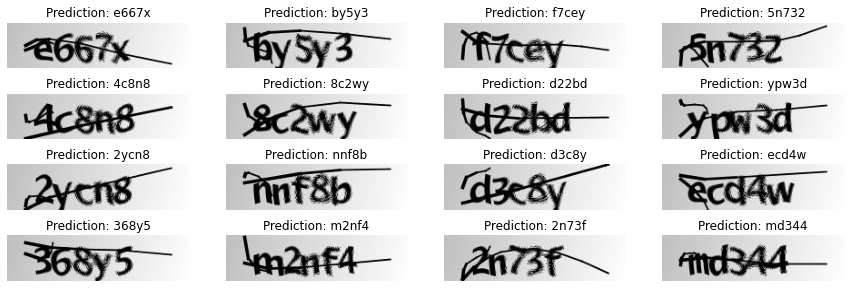

In [20]:
# Get the prediction model by extracting layers till the output layer
prediction_model = keras.models.Model(
    model.get_layer(name="image").input, model.get_layer(name="dense2").output
)
prediction_model.summary()

# A utility function to decode the output of the network
def decode_batch_predictions(pred):
    input_len = np.ones(pred.shape[0]) * pred.shape[1]
    # Use greedy search. For complex tasks, you can use beam search
    results = keras.backend.ctc_decode(pred, input_length=input_len, greedy=True)[0][0][
        :, :max_length
    ]
    # Iterate over the results and get back the text
    output_text = []
    for res in results:
        res = tf.strings.reduce_join(num_to_char(res)).numpy().decode("utf-8")
        output_text.append(res)
    return output_text


#  Let's check results on some validation samples
for batch in validation_dataset.take(1):
    batch_images = batch["image"]
    batch_labels = batch["label"]

    preds = prediction_model.predict(batch_images)
    pred_texts = decode_batch_predictions(preds)

    orig_texts = []
    for label in batch_labels:
        label = tf.strings.reduce_join(num_to_char(label)).numpy().decode("utf-8")
        orig_texts.append(label)

    _, ax = plt.subplots(4, 4, figsize=(15, 5))
    for i in range(len(pred_texts)):
        img = (batch_images[i, :, :, 0] * 255).numpy().astype(np.uint8)
        img = img.T
        title = f"Prediction: {pred_texts[i]}"
        ax[i // 4, i % 4].imshow(img, cmap="gray")
        ax[i // 4, i % 4].set_title(title)
        ax[i // 4, i % 4].axis("off")
plt.show()

Text(0.5, 1.0, 'Loss function wrt epochs')

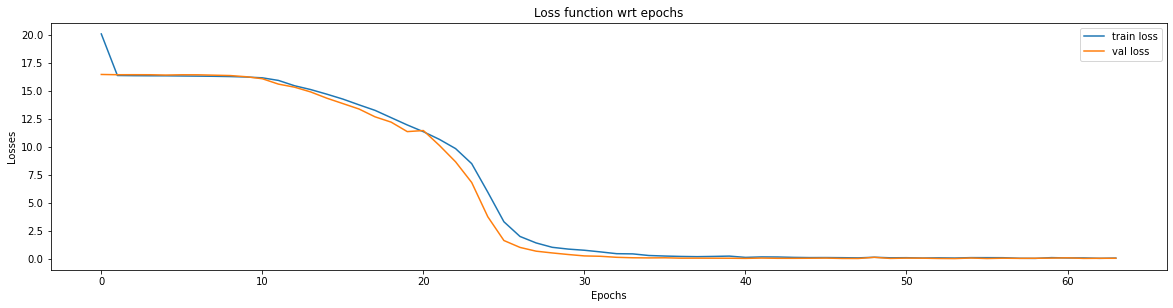

In [24]:
import matplotlib.pyplot as plt

plt.figure(figsize = (20,10))
plt.subplot(2,1,1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('Epochs')
plt.ylabel('Losses')
plt.legend(['train loss','val loss'])
plt.title('Loss function wrt epochs')